In [16]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
# Configuration
dataset_name = 'gossipcop'
feature_type = 'profile'   
edge_type = 'retweet'


In [18]:
# Load UPFD Dataset with Custom Split
train_dataset = UPFD(root=path, name=dataset_name, feature=feature_type, split='test')
val_dataset   = UPFD(root=path, name=dataset_name, feature=feature_type, split='train')
test_dataset  = UPFD(root=path, name=dataset_name, feature=feature_type, split='val')

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Input dim: {train_dataset.num_node_features}, Classes: {train_dataset.num_classes}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128)
test_loader  = DataLoader(test_dataset, batch_size=128)

Train: 3826, Val: 1092, Test: 546
Input dim: 10, Classes: 2


In [19]:
# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [20]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(train_dataset.num_node_features, 64, train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training & Evaluation Functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.y = data.y.to(torch.long)
        assert torch.all(data.y >= 0) and torch.all(data.y < model.lin.out_features), \
            f"Invalid label(s) in batch: {data.y}"
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = total = 0
    for data in loader:
        data = data.to(device)
        data.y = data.y.to(torch.long)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs
    return correct / total

In [21]:
# Run Training
best_val_acc = 0.0
best_model_state = None

for epoch in range(1, 101):
    loss = train()
    val_acc = evaluate(val_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

os.makedirs("../models", exist_ok=True)
torch.save(best_model_state, "../models/gcn_best_model.pt")

# Final Evaluation
model.load_state_dict(best_model_state)
print(f"\n Loaded Best Model (Val Acc = {best_val_acc:.4f})")
test_acc = evaluate(test_loader)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

Epoch 01 | Loss: 0.6841 | Val Acc: 0.5916
Epoch 02 | Loss: 0.6485 | Val Acc: 0.6667
Epoch 03 | Loss: 0.5870 | Val Acc: 0.7198
Epoch 04 | Loss: 0.5200 | Val Acc: 0.7940
Epoch 05 | Loss: 0.4685 | Val Acc: 0.8187
Epoch 06 | Loss: 0.4303 | Val Acc: 0.8370
Epoch 07 | Loss: 0.4076 | Val Acc: 0.8306
Epoch 08 | Loss: 0.3927 | Val Acc: 0.8471
Epoch 09 | Loss: 0.3784 | Val Acc: 0.8599
Epoch 10 | Loss: 0.3650 | Val Acc: 0.8663
Epoch 11 | Loss: 0.3591 | Val Acc: 0.8727
Epoch 12 | Loss: 0.3529 | Val Acc: 0.8690
Epoch 13 | Loss: 0.3491 | Val Acc: 0.8745
Epoch 14 | Loss: 0.3449 | Val Acc: 0.8773
Epoch 15 | Loss: 0.3401 | Val Acc: 0.8764
Epoch 16 | Loss: 0.3367 | Val Acc: 0.8828
Epoch 17 | Loss: 0.3374 | Val Acc: 0.8736
Epoch 18 | Loss: 0.3316 | Val Acc: 0.8828
Epoch 19 | Loss: 0.3285 | Val Acc: 0.8837
Epoch 20 | Loss: 0.3266 | Val Acc: 0.8800
Epoch 21 | Loss: 0.3272 | Val Acc: 0.8800
Epoch 22 | Loss: 0.3272 | Val Acc: 0.8764
Epoch 23 | Loss: 0.3225 | Val Acc: 0.8874
Epoch 24 | Loss: 0.3220 | Val Acc:


 GCN Results (GossipCop):
              precision    recall  f1-score   support

        Fake       0.91      0.92      0.92       265
        Real       0.93      0.92      0.92       281

    accuracy                           0.92       546
   macro avg       0.92      0.92      0.92       546
weighted avg       0.92      0.92      0.92       546



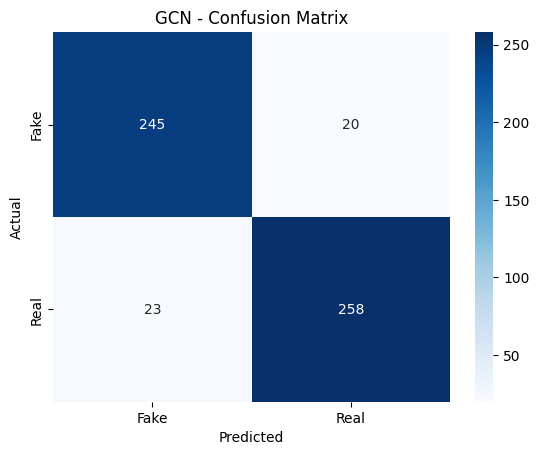

In [22]:
# Predict on Test Set
y_true, y_pred = [], []
model = GCN(train_dataset.num_node_features, 64, train_dataset.num_classes).to(device)
model.load_state_dict(torch.load("../models/gcn_best_model.pt"))
model.eval()

for data in test_loader:
    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch)
    preds = out.argmax(dim=1).cpu().numpy()
    labels = data.y.cpu().numpy()

    y_pred.extend(preds)
    y_true.extend(labels)

# Classification Report
print("\n GCN Results (GossipCop):")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("GCN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
